In [ ]:
# created Aug 4 by G Oldford to explore 
#  temporal crosscorrelation between model and obs
# will take LH SSS time series and model and apply moving average 
# then rescore
# input is output from analyze.py in pyap 

In [95]:
import scipy.io
import os
import pickle
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats
import sys
from matplotlib import rcParams
from matplotlib.markers import MarkerStyle
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.colors as clr
from matplotlib.ticker import ScalarFormatter
import math
from math import log10, floor
from array import array
import numbers
from matplotlib.lines import Line2D
import warnings
from matplotlib.markers import MarkerStyle
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import calendar

In [7]:
# get lighthouse data

modelruns_info = {#'SalishSea1500-RUN203': {'path': 'D:/temp_nemo/RUN203_PLOTS_SCORES/',
#                                            'colour': 'r', 
#                                            'shortcode': 'RUN203', 'experiment': False}, 
                      'SalishSea1500-RUN216': {'path': 'D:/temp_nemo/RUN216/',
                                            'colour': 'b', 
                                           'shortcode': 'RUN216', 'experiment': False}#,
#                      'SalishSea500-201905': {'path': 'D:/temp_nemo/SS500/',
#                                            'colour': 'g', 
#                                            'shortcode': '201905', 'experiment': True}
                 }

modelrun = 'SalishSea1500-RUN216'
shortcode = modelruns_info[modelrun]['shortcode']
path1 = modelruns_info[modelrun]['path']

LH_pic_data = 'LH_class4_' + shortcode + '_hindcast.pickle'
LH_scores = pickle.load(open(os.path.join(path1,LH_pic_data), 'rb'))

In [8]:
LH_scores

{'SalishSea1500-RUN216': {'active_pass_LH.nc': {'lat': array(48.873, dtype=float32),
   'lon': array(-123.292, dtype=float32),
   'start': datetime.datetime(1980, 1, 1, 7, 0, 16),
   'end': datetime.datetime(2011, 12, 31, 10, 1, 36),
   'obs_file(s)': ['/project/6006412/goldford/OBS-WEST/LH/active_pass_LH.nc'],
   'raw_data': {'temperature': array([8.15581404, 8.0320538 , 8.08926041, ..., 6.29941324, 6.22834092,
           6.1989484 ]),
    'salinity': array([28.4393807 , 28.34369624, 28.46763234, ..., 25.63159206,
           25.55065414, 25.55231385]),
    'time': array([datetime.datetime(1980, 1, 1, 8, 0),
           datetime.datetime(1980, 1, 1, 9, 0),
           datetime.datetime(1980, 1, 1, 10, 0), ...,
           datetime.datetime(2018, 12, 31, 10, 0),
           datetime.datetime(2018, 12, 31, 11, 0),
           datetime.datetime(2018, 12, 31, 12, 0)], dtype=object),
    'station': 'active_pass',
    'filename': '/project/6006412/goldford/ANALYSIS/SalishSea1500-RUN216/EXTRACT/LH

In [18]:
print(len(LH_scores['SalishSea1500-RUN216']['active_pass_LH.nc']['filt_interp_data']['salinity']))
print(len(LH_scores['obs']['active_pass_LH.nc']['filt_interp_data']['salinity']))

11490
11490


In [30]:
obs_ts = (LH_scores['obs']['active_pass_LH.nc']['filt_interp_data']['timeseries']
LH_scores[modelrun]['active_pass_LH.nc']['filt_interp_data'].keys()

dict_keys(['scores', 'temperature', 'time', 'salinity'])

In [39]:
np.asarray(obs_ts[0])

array('time', dtype='<U4')

In [46]:
LH_scores['obs']['race_rocks_LH.nc']['filt_interp_data']['timeseries'][:]

['time', 'temperature', 'salinity']

In [160]:
def apply_2wk_filter(time_sorted, salt_sorted, use_nanmean=True):
    # Calculate the moving average with a two-week time step
    two_weeks_in_seconds = 2 * 7 * 24 * 60 * 60
    result_time = []
    result_salt = []

    start_time = time_sorted[0]
    end_time = time_sorted[-1]

    current_time = start_time
    while current_time <= end_time:
        time_mask = (time_sorted >= current_time) & (time_sorted < current_time + two_weeks_in_seconds)
        if use_nanmean:
            average_salt = np.nanmean(salt_sorted[time_mask])
        else:
            average_salt = np.mean(salt_sorted[time_mask])

        result_time.append(current_time)
        result_salt.append(average_salt)

        current_time += two_weeks_in_seconds

    # Convert the result_time back to datetime objects
    result_time = [datetime.fromtimestamp(ts) for ts in result_time]

    # Convert the result arrays to numpy arrays
    result_time = np.array(result_time)
    result_salt = np.array(result_salt)

    return result_time, result_salt

def seconds_in_one_month(year, month):
    _, num_days = calendar.monthrange(year, month)
    return num_days * 24 * 60 * 60


def apply_1mo_filter(time_sorted, salt_sorted, use_nanmean=True):
    # Find the start and end time
    start_time = datetime.fromtimestamp(time_sorted[0])
    end_time = datetime.fromtimestamp(time_sorted[-1])

    result_time = []
    result_salt = []

    current_time = start_time
    while current_time <= end_time:
        # Calculate the end of the current month
        end_of_month = current_time.replace(day=calendar.monthrange(current_time.year, current_time.month)[1])
        end_of_month = end_of_month.replace(hour=23, minute=59, second=59)

        # Create a time mask for the current month
        time_mask = (time_sorted >= current_time.timestamp()) & (time_sorted <= end_of_month.timestamp())

        # Calculate the average salt concentration for the current month
        if use_nanmean:
            average_salt = np.nanmean(salt_sorted[time_mask])
        else:
            average_salt = np.mean(salt_sorted[time_mask])

        result_time.append(current_time.timestamp())
        result_salt.append(average_salt)

        # Move to the next month
        current_time = end_of_month + timedelta(seconds=1)

    # Convert the result_time back to datetime objects
    result_time = [datetime.fromtimestamp(ts) for ts in result_time]

    # Convert the result arrays to numpy arrays
    result_time = np.array(result_time)
    result_salt = np.array(result_salt)
    return result_time, result_salt


# seasonal filter
def apply_3mo_filter(time_sorted, salt_sorted, use_nanmean=True):

    three_months_in_seconds = 3 * 30 * 24 * 60 * 60

    result_time = []
    result_salt = []

    start_time = datetime.fromtimestamp(time_combined_sorted[0])
    end_time = datetime.fromtimestamp(time_combined_sorted[-1])

    current_time = start_time
    while current_time <= end_time:
        # Calculate the end of the 4-month period
        end_of_period = current_time + timedelta(seconds=three_months_in_seconds)

        # Create a time mask for the current 4-month period
        time_mask = (time_sorted >= current_time.timestamp()) & (time_sorted < end_of_period.timestamp())

        # Calculate the average salt concentration for the current 4-month period
        if use_nanmean:
            average_salt = np.nanmean(salt_sorted[time_mask])
        else:
            average_salt = np.mean(salt_sorted[time_mask])

        result_time.append(current_time.timestamp())
        result_salt.append(average_salt)

        current_time += timedelta(seconds=three_months_in_seconds)

    # Convert the result_time back to datetime objects
    result_time = [datetime.fromtimestamp(ts) for ts in result_time]

    # Convert the result arrays to numpy arrays
    result_time = np.array(result_time)
    result_salt = np.array(result_salt)
    return result_time, result_salt


# alt pearsons R
def pearson2 (obs, mod):
    mod = np.asarray(mod)
    obs = np.asarray(obs)
    R = (1 / (np.nanstd(mod) * np.nanstd(obs)) ) * (np.sum( (mod - np.nanmean(mod)) * (obs - np.nanmean(obs)) )  / len(obs))
    return R

In [161]:

lh = 'chrome_island_LH.nc'
use_nanmean = True

# get data from original dictionary format
time_obs = np.asarray(LH_scores['obs'][lh]['filt_interp_data']['time'])
salt_obs = np.asarray(LH_scores['obs'][lh]['filt_interp_data']['salinity'].astype('f'))
time_mod = np.asarray(LH_scores[modelrun][lh]['filt_interp_data']['time'])
salt_mod = np.asarray(LH_scores[modelrun][lh]['filt_interp_data']['salinity'].astype('f'))

# format to datetime
time_obs_numeric = np.array([dt.timestamp() for dt in time_obs])
time_mod_numeric = np.array([dt.timestamp() for dt in time_mod])

# sort
sort_indices = np.argsort(time_obs_numeric)
time_sort_o = time_obs_numeric[sort_indices]
salt_sort_o = salt_obs[sort_indices]

sort_indices = np.argsort(time_mod_numeric)
time_sort_m = time_mod_numeric[sort_indices]
salt_sort_m = salt_mod[sort_indices]

# get two week moving avg
time_2wk_o, s_2wk_o = apply_2wk_filter(time_sort_o, salt_sort_o, use_nanmean)
time_2wk_m, s_2wk_m = apply_2wk_filter(time_sort_m, salt_sort_m, use_nanmean)

# get monthly moving avg
time_1mo_o, s_1mo_o = apply_1mo_filter(time_sort_o, salt_sort_o, use_nanmean)
time_1mo_m, s_1mo_m = apply_1mo_filter(time_sort_m, salt_sort_m, use_nanmean)

# get seasonal moving avg
time_3mo_o, s_3mo_o = apply_3mo_filter(time_sort_o, salt_sort_o, use_nanmean)
time_3mo_m, s_3mo_m = apply_3mo_filter(time_sort_m, salt_sort_m, use_nanmean)


# Now you have the two-week moving average data in result_time and result_salt arrays

C:\Users\Greig\AppData\Local\Temp\ipykernel_11992\3614285754.py:14: RuntimeWarning: Mean of empty slice
  average_salt = np.nanmean(salt_sorted[time_mask])
C:\Users\Greig\AppData\Local\Temp\ipykernel_11992\3614285754.py:56: RuntimeWarning: Mean of empty slice
  average_salt = np.nanmean(salt_sorted[time_mask])


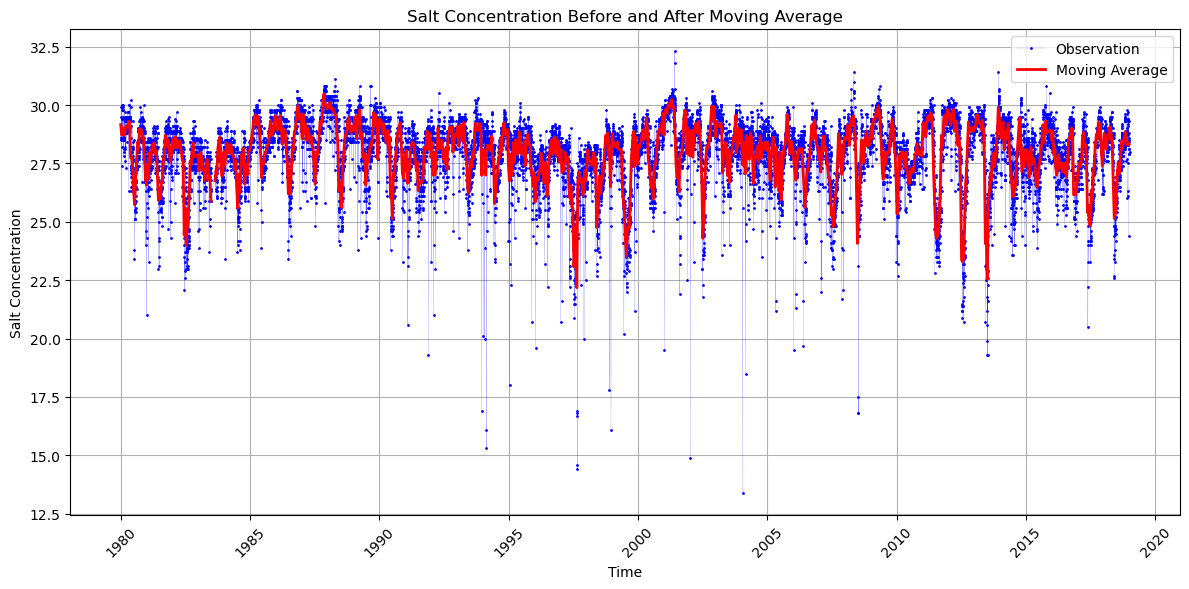

In [127]:
plt.figure(figsize=(12, 6))

# Plot the original data
plt.plot(time_obs, salt_obs, label='Observation', color='b', marker='o', linestyle='-', markersize=1, linewidth=0.1, zorder=10)
# plt.plot(time_mod, salt_mod, label='Model', color='g', marker='o', linestyle='-', markersize=4)

# Plot the data after applying the moving average
plt.plot(time_2wk_o, s_2wk_o, label='Moving Average', color='r', linewidth=2, zorder=10)

plt.xlabel('Time')
plt.ylabel('Salt Concentration')
plt.title('Salt Concentration Before and After Moving Average (obs)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


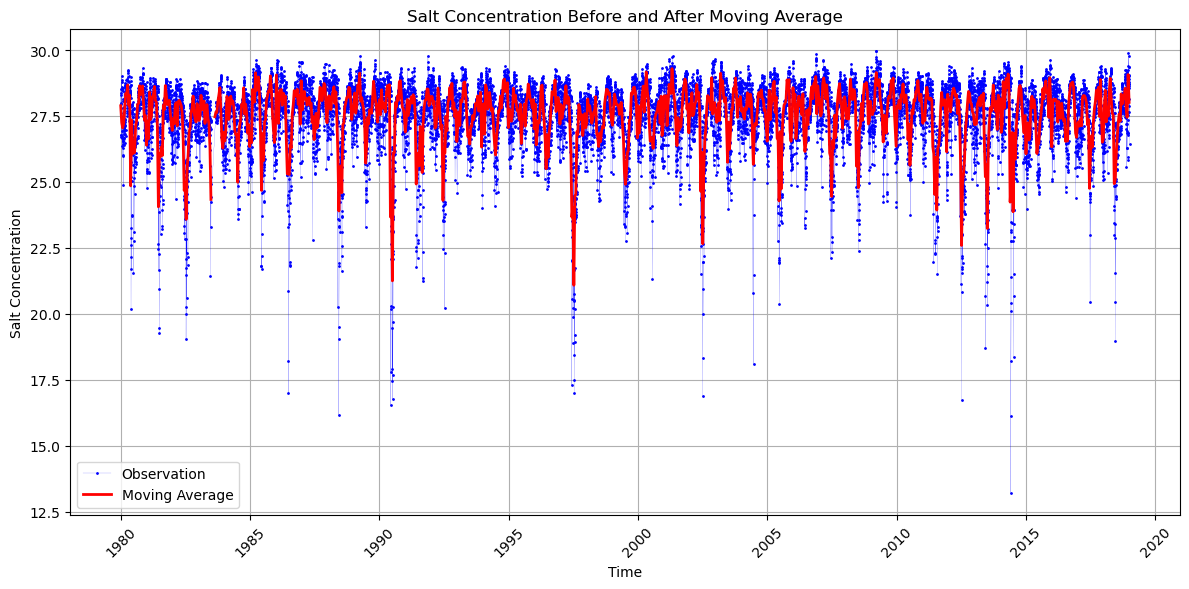

In [128]:
plt.figure(figsize=(12, 6))

# Plot the original data
plt.plot(time_mod, salt_mod, label='Model', color='b', marker='o', linestyle='-', markersize=1, linewidth=0.1, zorder=10)
# plt.plot(time_mod, salt_mod, label='Model', color='g', marker='o', linestyle='-', markersize=4)

# Plot the data after applying the moving average
plt.plot(time_2wk_m, s_2wk_m, label='Moving Average', color='r', linewidth=2, zorder=10)

plt.xlabel('Time')
plt.ylabel('Salt Concentration')
plt.title('Salt Concentration Before and After Moving Average (model)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

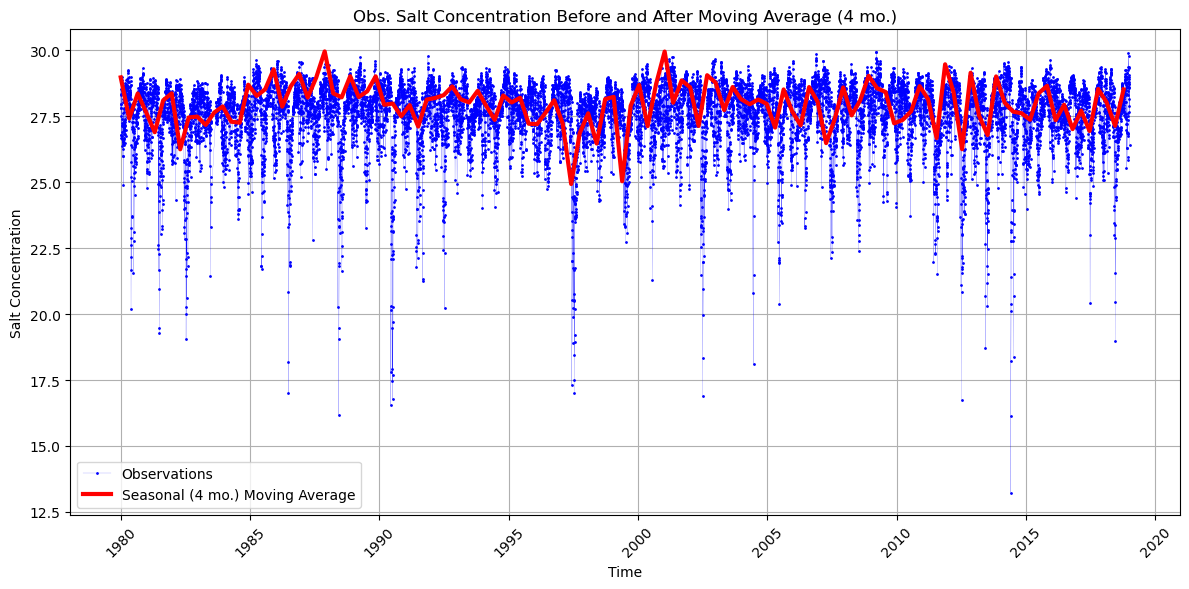

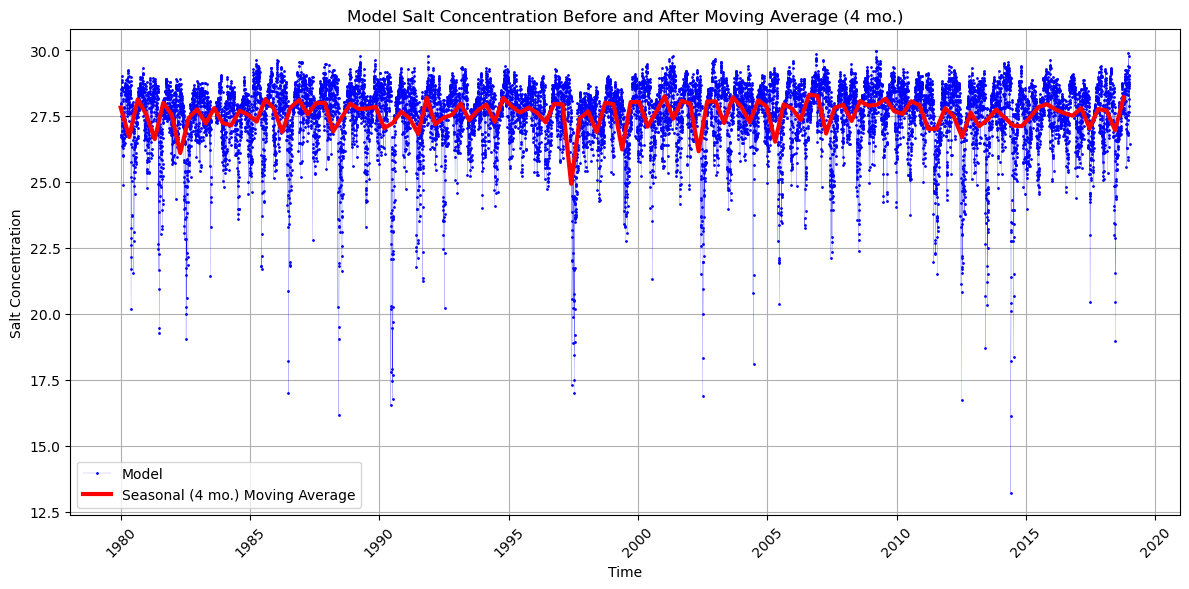

In [158]:
plt.figure(figsize=(12, 6))

# Plot the original data
plt.plot(time_mod, salt_mod, label='Observations', color='b', marker='o', linestyle='-', markersize=1, linewidth=0.1, zorder=10)
# plt.plot(time_mod, salt_mod, label='Model', color='g', marker='o', linestyle='-', markersize=4)

# Plot the data after applying the moving average
plt.plot(time_4mo_o, s_4mo_o, label='Seasonal (4 mo.) Moving Average', color='r', linewidth=3, zorder=10)

plt.xlabel('Time')
plt.ylabel('Salt Concentration')
plt.title('Obs. Salt Concentration Before and After Moving Average (4 mo.)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))

# Plot the original data
plt.plot(time_mod, salt_mod, label='Model', color='b', marker='o', linestyle='-', markersize=1, linewidth=0.1, zorder=10)
# plt.plot(time_mod, salt_mod, label='Model', color='g', marker='o', linestyle='-', markersize=4)

# Plot the data after applying the moving average
plt.plot(time_4mo_m, s_4mo_m, label='Seasonal (4 mo.) Moving Average', color='r', linewidth=3, zorder=10)

plt.xlabel('Time')
plt.ylabel('Salt Concentration')
plt.title('Model Salt Concentration Before and After Moving Average (4 mo.)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


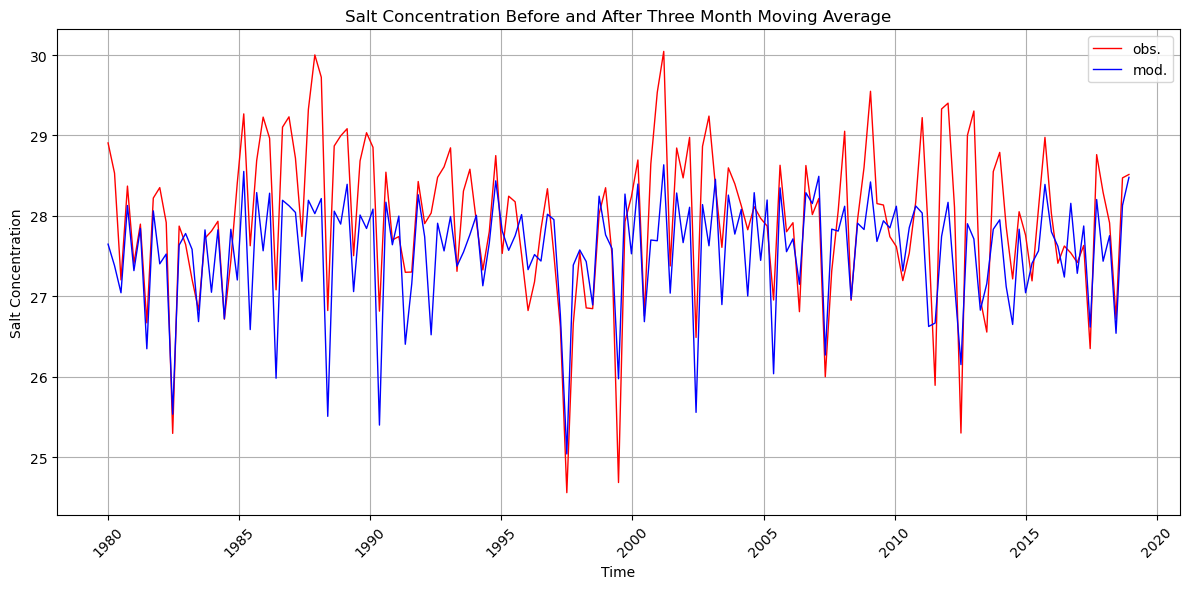

In [163]:
plt.figure(figsize=(12, 6))

# Plot the original dThree
# plt.plot(time_mod, salt_mod, label='Observation', color='b', marker='o', linestyle='-', markersize=1, linewidth=0.1, zorder=10)
# plt.plot(time_mod, salt_mod, label='Model', color='g', marker='o', linestyle='-', markersize=4)
# plt.plot(time_mod, salt_mod, label='Observations', color='b', marker='o', linestyle='-', markersize=1, linewidth=0.1, zorder=10)


# Plot the data after applying the moving average
plt.plot(time_3mo_o, s_3mo_o, label='obs.', color='r', linewidth=1)
plt.plot(time_3mo_m, s_3mo_m, label='mod.', color='b', linewidth=1)


plt.xlabel('Time')
plt.ylabel('Salt Concentration')
plt.title('Salt Concentration Before and After Three Month Moving Average')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [165]:
# No moving average
salt_sort_m_nonan = salt_sort_m[~np.isnan(salt_sort_m) & ~np.isnan(salt_sort_o)]
salt_sort_o_nonan = salt_sort_o[~np.isnan(salt_sort_o) & ~np.isnan(salt_sort_m)]
                        

ccoeff = np.corrcoef(salt_sort_m_nonan,salt_sort_o_nonan)
# ccoeff = sp.stats.pearsonr(s_1mo_m_nonan, s_1mo_o_nonan) 

# Calculate standard deviation for both datasets
std_salt_obs = np.nanstd(salt_sort_o)
std_salt_mod = np.nanstd(salt_sort_m)

print('##################')
print("No Moving Average")
print("Pearson's Correlation Coefficient (R):", ccoeff[0,1])
print("Standard Deviation of salt_obs:", std_salt_obs)
print("Standard Deviation of salt_mod:", std_salt_mod)


# Two week stats

s_2wk_o_nonan = s_2wk_o[~np.isnan(s_2wk_o) & ~np.isnan(s_2wk_m)]
s_2wk_m_nonan = s_2wk_m[~np.isnan(s_2wk_m) & ~np.isnan(s_2wk_o)]
                        

ccoeff = np.corrcoef(s_2wk_m_nonan,s_2wk_o_nonan)
# ccoeff = sp.stats.pearsonr(s_1mo_m_nonan, s_1mo_o_nonan) 

# Calculate standard deviation for both datasets
std_salt_obs = np.nanstd(s_2wk_o)
std_salt_mod = np.nanstd(s_2wk_m)

print('##################')
print("Two week Moving Avg")
print("Pearson's Correlation Coefficient (R):", ccoeff[0,1])
print("Standard Deviation of salt_obs:", std_salt_obs)
print("Standard Deviation of salt_mod:", std_salt_mod)


# One mOnth stats

s_1mo_o_nonan = s_1mo_o[~np.isnan(s_1mo_o) & ~np.isnan(s_1mo_m)]
s_1mo_m_nonan = s_1mo_m[~np.isnan(s_1mo_m) & ~np.isnan(s_1mo_o)]
                        

ccoeff = np.corrcoef(s_1mo_m_nonan,s_1mo_o_nonan)
# ccoeff = sp.stats.pearsonr(s_1mo_m_nonan, s_1mo_o_nonan) 

# Calculate standard deviation for both datasets
std_salt_obs = np.nanstd(s_1mo_o)
std_salt_mod = np.nanstd(s_1mo_m)

print('##################')
print("One Month Moving Avg")
print("Pearson's Correlation Coefficient (R):", ccoeff[0,1])
print("Standard Deviation of salt_obs:", std_salt_obs)
print("Standard Deviation of salt_mod:", std_salt_mod)

# 3 month stats

s_3mo_o_nonan = s_3mo_o[~np.isnan(s_3mo_o) & ~np.isnan(s_3mo_m)]
s_3mo_m_nonan = s_3mo_m[~np.isnan(s_3mo_m) & ~np.isnan(s_3mo_o)]
                        

ccoeff = np.corrcoef(s_3mo_m_nonan,s_3mo_o_nonan)
# ccoeff = sp.stats.pearsonr(s_1mo_m_nonan, s_1mo_o_nonan) 

# Calculate standard deviation for both datasets
std_salt_obs = np.nanstd(s_3mo_o)
std_salt_mod = np.nanstd(s_3mo_m)

print('##################')
print("One Three Moving Avg")
print("Pearson's Correlation Coefficient (R):", ccoeff[0,1])
print("Standard Deviation of salt_obs:", std_salt_obs)
print("Standard Deviation of salt_mod:", std_salt_mod)

##################
No Moving Average
Pearson's Correlation Coefficient (R): 0.556096558014842
Standard Deviation of salt_obs: 1.4767157
Standard Deviation of salt_mod: 1.3194315
##################
Two week Moving Avg
Pearson's Correlation Coefficient (R): 0.7123197521539038
Standard Deviation of salt_obs: 1.2034959
Standard Deviation of salt_mod: 1.0255462
##################
One Month Moving Avg
Pearson's Correlation Coefficient (R): 0.7522194039555168
Standard Deviation of salt_obs: 1.1386381
Standard Deviation of salt_mod: 0.919608
##################
One Three Moving Avg
Pearson's Correlation Coefficient (R): 0.7694148378730115
Standard Deviation of salt_obs: 0.94654185
Standard Deviation of salt_mod: 0.69454724


In [ ]:
# Step 4: Calculate the seasonal moving average
